In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

labels.csv and processed_counts.csv files associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [3]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [4]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [5]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shuffle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


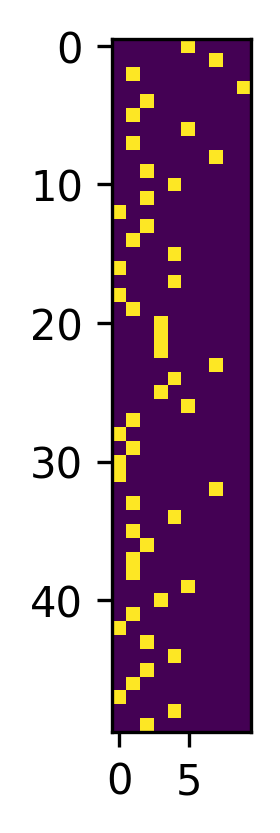

In [6]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [8]:
# Decode one-hot encodings to get a 2D vector of class labels 0-9 corresponding to specific class
y_train1d = np.argmax(y_train, axis=1)
y_test1d = np.argmax(y_test, axis=1)

In [17]:
# RandomForest Model with tuned hyperparameters
rf_model = RandomForestClassifier(n_estimators=100,
                                  min_samples_split=10,
                                  max_depth=10,
                                  random_state=0,
                                  max_features='log2',
                                  bootstrap=False,
                                  class_weight='balanced')
fitted_model = rf_model.fit(X_train, y_train1d) # train the randomforest using cell data

y_pred = fitted_model.predict(X_test) # predict method outputs predicted labels

#print(y_pred[:50])
#print(y_test1d[:50])

accuracy = accuracy_score(y_test1d, y_pred) # sklearn accuracy
class_accuracy = classification_report(y_test1d, y_pred) # classification precision, recall, f1-score table
f1 = f1_score(y_test1d, y_pred, average='macro') # f1 score

print("Macro F1-score:", f1)
print(f"Accuracy Score: {accuracy}")
print(class_accuracy)

Macro F1-score: 0.6489843629759596
Accuracy Score: 0.8285714285714286
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        30
           1       0.90      0.86      0.88        50
           2       0.83      0.83      0.83         6
           3       0.64      0.90      0.75        10
           4       1.00      1.00      1.00        15
           5       0.75      0.64      0.69        14
           6       0.00      0.00      0.00         1
           7       0.75      0.67      0.71         9
           8       0.00      0.00      0.00         2
           9       1.00      0.67      0.80         3

    accuracy                           0.83       140
   macro avg       0.66      0.65      0.65       140
weighted avg       0.82      0.83      0.82       140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.model_selection import GridSearchCV

# Gridsearch to test parameters for random forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
    }

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train1d)

print("Best params:", grid_search.best_params_)
print("Best f1_macro score:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
Best f1_macro score: 0.6571404427935471


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Adaboost model to compare classifier types
# hyperparameters tuned to acheive at least 80% accuracy
ada_model = AdaBoostClassifier(
    n_estimators=375,
    learning_rate=2.5,
    estimator=DecisionTreeClassifier(max_depth=10)
)

ada_fitted_model = ada_model.fit(X_train, y_train1d)
y_pred_ada = ada_fitted_model.predict(X_test)

accuracy_ada = accuracy_score(y_test1d, y_pred_ada)
class_accuracy_ada = classification_report(y_test1d, y_pred_ada)
f1_ada = f1_score(y_test1d, y_pred_ada, average='macro')

print("Macro F1-score:", f1_ada)
print(f"Accuracy Score: {accuracy_ada}")
print(class_accuracy_ada)

Macro F1-score: 0.6558452877172088
Accuracy Score: 0.8214285714285714
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        30
           1       0.90      0.86      0.88        50
           2       0.83      0.83      0.83         6
           3       0.62      1.00      0.77        10
           4       1.00      0.93      0.97        15
           5       0.67      0.57      0.62        14
           6       0.00      0.00      0.00         1
           7       0.83      0.56      0.67         9
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         3

    accuracy                           0.82       140
   macro avg       0.66      0.67      0.66       140
weighted avg       0.81      0.82      0.81       140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

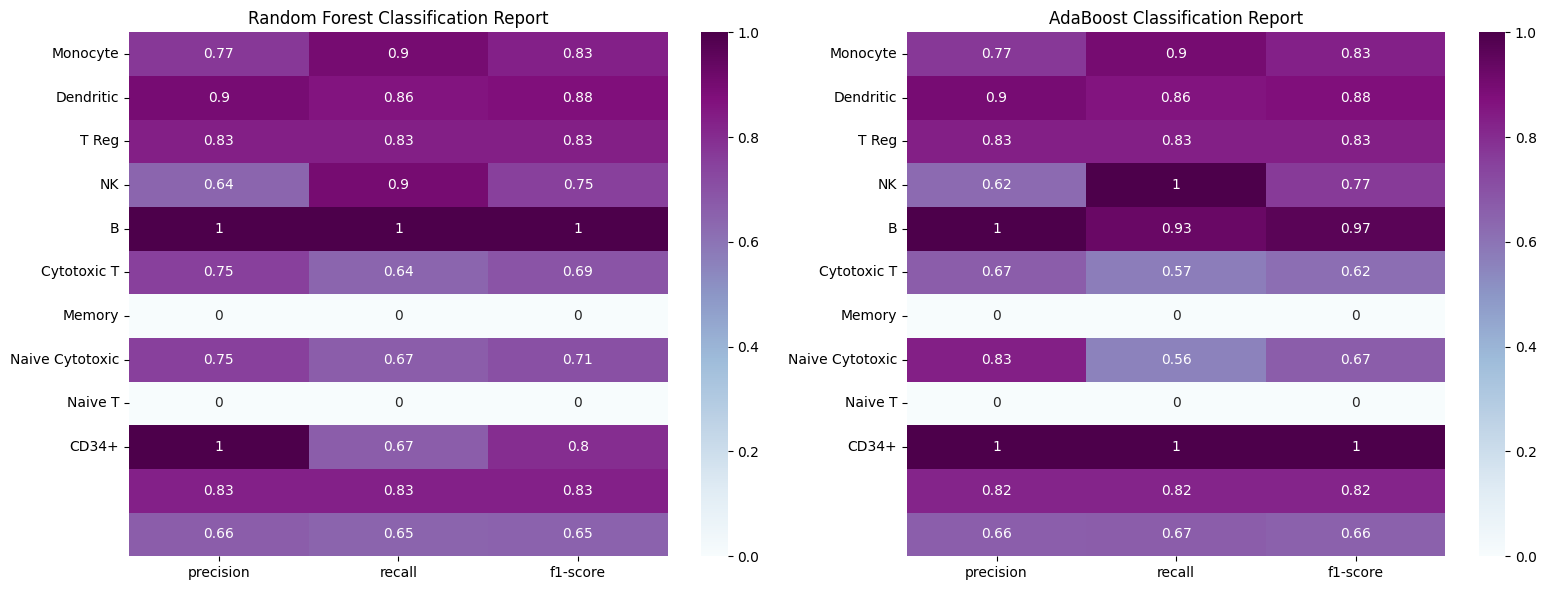

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels = ['Monocyte', 'Dendritic', 'T Reg', 'NK', 'B', 'Cytotoxic T', 'Memory', 'Naive Cytotoxic', 'Naive T', 'CD34+']
#Plot each classficatinon report as a confusion matrix
rf_report = classification_report(y_test1d, y_pred, output_dict=True)
ada_report = classification_report(y_test1d, y_pred_ada, output_dict=True)

df_rf = pd.DataFrame(rf_report).transpose()
df_ada = pd.DataFrame(ada_report).transpose()

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

sns.heatmap(df_rf.iloc[:-1, :-1], annot=True, cmap="BuPu", ax=axes[0], yticklabels=labels)
axes[0].set_title("Random Forest Classification Report")

sns.heatmap(df_ada.iloc[:-1, :-1], annot=True, cmap="BuPu", ax=axes[1], yticklabels=labels)
axes[1].set_title("AdaBoost Classification Report")

axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

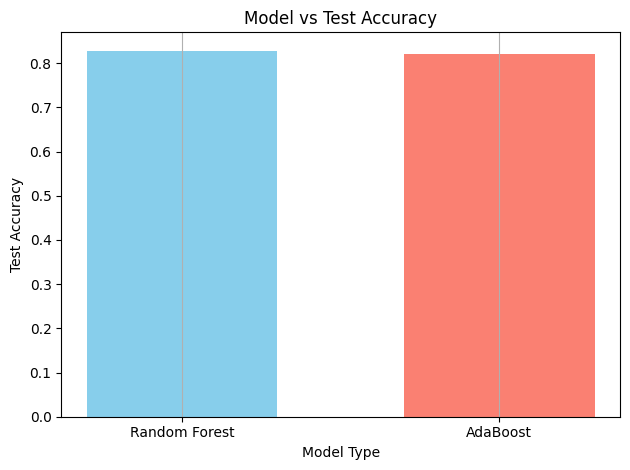

In [20]:
models = ['Random Forest', 'AdaBoost']
accuracies = [accuracy, accuracy_ada]

# Plot accuracy score in barplot
plt.grid(axis='x')  # Turns off grid lines

plt.bar(models, accuracies, color=['skyblue', 'salmon'], width=0.6)
plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.title('Model vs Test Accuracy')
plt.tight_layout()

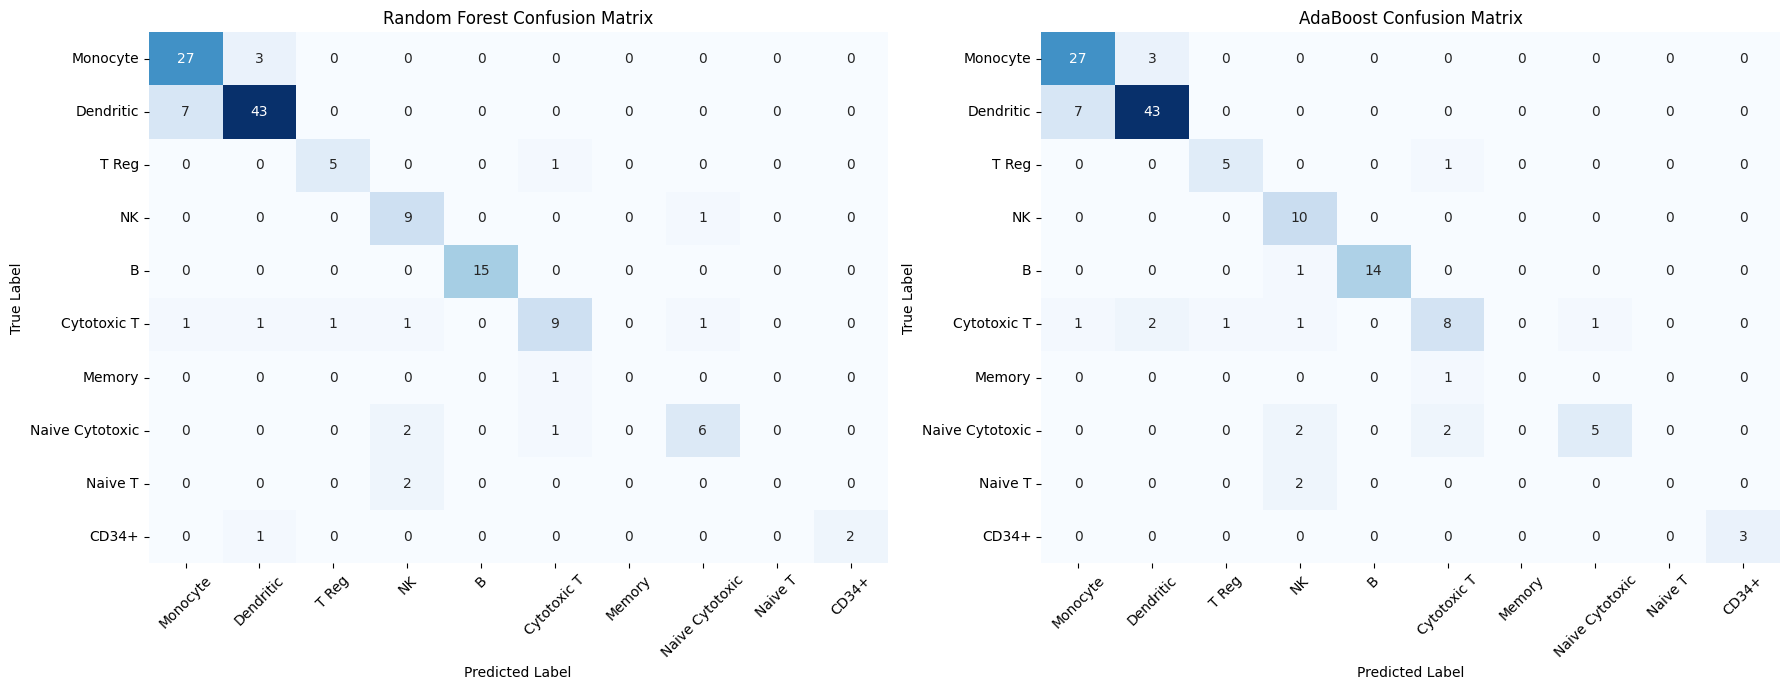

In [21]:
from sklearn.metrics import confusion_matrix
c_rf = confusion_matrix(y_test1d, y_pred)
c_ada = confusion_matrix(y_test1d, y_pred_ada)

labels = ['Monocyte', 'Dendritic', 'T Reg', 'NK', 'B', 'Cytotoxic T', 'Memory', 'Naive Cytotoxic', 'Naive T', 'CD34+']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Random Forest heatmap
sns.heatmap(c_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].tick_params(axis='x', labelrotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# AdaBoost heatmap
sns.heatmap(c_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("AdaBoost Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].tick_params(axis='x', labelrotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

# Layout adjustment
plt.tight_layout()
plt.show()